<a href="https://colab.research.google.com/github/prcm066/cancer_detection_example/blob/main/gans_art_creation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## GAN Art creation

In this notebook we are going to explore the use of Generative Adversarial Networks for genrative tasks.
I forked this notebook from [Sairaj Adhav](https://www.kaggle.com/code/sai10py/gans-art-creation). Shout out to Sairaj, his notebook is even clearer that the oficial tutorial in the competitions landing page and we are going to following it closely. The main difference are adjustments in terms of computational resources:

* Use of GPU's vs TPU's
* Reduced number of Epochs, to ensure that the process runs in a fraction of the alloted time.

  Even with this reductions, the results were adequate:

  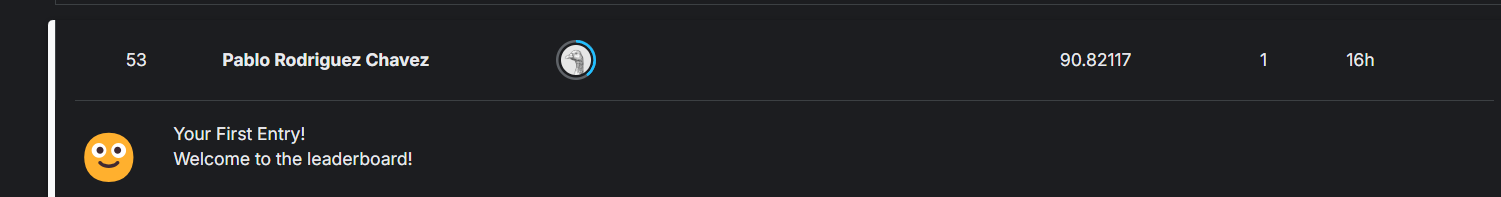


### Loading dependencies and datafiles

In [ ]:
import os
import PIL
import shutil
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, BatchNormalization, LeakyReLU, ReLU, Input
import matplotlib.pyplot as plt
from kaggle_datasets import KaggleDatasets

The following code block is used to retrieve image file paths from a dataset stored in Google Cloud Storage (GCS), specifically from Kaggle Datasets, and count the number of images in two categories: **Monet paintings** and **Photos**.

In [ ]:
# Define the data path from Kaggle Datasets
GCS_PATH = KaggleDatasets().get_gcs_path()

In [ ]:
# Retrieve image file paths
MONET_FILENAMES = tf.io.gfile.glob(str(GCS_PATH + '/monet_jpg/*.jpg'))
PHOTO_FILENAMES = tf.io.gfile.glob(str(GCS_PATH + '/photo_jpg/*.jpg'))

- `tf.io.gfile.glob(pattern)` is a TensorFlow function that finds all files matching a given pattern.

- `GCS_PATH + '/monet_jpg/*.jpg` specifies that it should find all `.jpg` files inside the `monet_jpg` folder.

- `GCS_PATH + '/photo_jpg/*.jpg` does the same for the `photo_jpg` folder.

In [ ]:
print('Monet jpg Files:', len(MONET_FILENAMES))
print('Photo jpg Files:', len(PHOTO_FILENAMES))

Monet jpg Files: 300
Photo jpg Files: 7038


## Exploratory Data Analysis

Monet image shape: (256, 256, 3)
Photo image shape: (256, 256, 3)


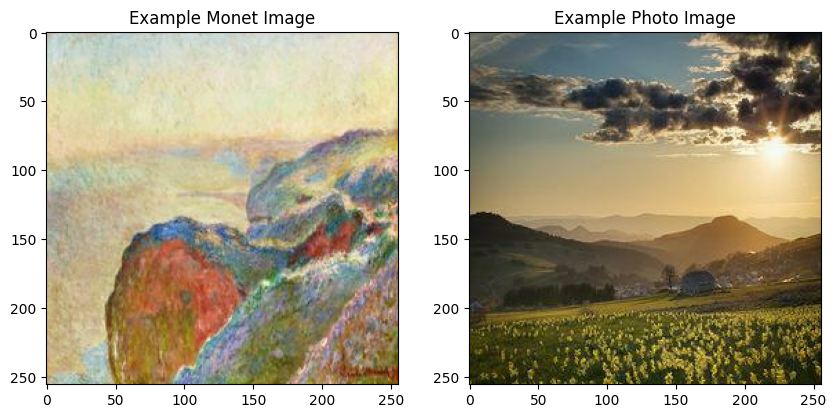

In [ ]:
# Load and display an example Monet image & Photo image
if MONET_FILENAMES and PHOTO_FILENAMES:
    example_monet_path = MONET_FILENAMES[0]
    monet_image = tf.io.read_file(example_monet_path)
    monet_image = tf.image.decode_jpeg(monet_image, channels=3)
    print("Monet image shape:", monet_image.shape)

    example_photo_path = PHOTO_FILENAMES[0]
    photo_image = tf.io.read_file(example_photo_path)
    photo_image = tf.image.decode_jpeg(photo_image, channels=3)
    print("Photo image shape:", photo_image.shape)

    # Display the images side by side
    plt.figure(figsize=(10, 5))

    # Show Monet image in the first subplot
    plt.subplot(1, 2, 2)
    plt.imshow(photo_image.numpy())
    plt.title("Example Photo Image")

    # Show Photo image in the second subplot
    plt.subplot(1, 2, 1)
    plt.imshow(monet_image.numpy())
    plt.title("Example Monet Image")

    plt.show()

According to the description given in the data section, all images are of size 256x256 in `JPEG` format. So there is no need to resize images.
Since these images are in RGB format, we set the number of channels to 3. Additionally, we scale the pixel values to the range [-1, 1] for proper normalization.

In [ ]:
IMAGE_SIZE = [256, 256]
# This function is responsible for loading, decoding
# normalizing, and reshaping an image from a given file path.
def decode_image(image_path):
    image = tf.io.read_file(image_path) # loads image as binary string from image path
    image = tf.image.decode_jpeg(image, channels=3) # decodes jpeg image into a TF tensor with 3 color channels
    image = (tf.cast(image, tf.float32)/127.5) - 1 # image tensor to tf.float32; Scaling pixel values
    image = tf.reshape(image, [*IMAGE_SIZE, 3]) # Ensures shape of (256, 256, 3)
    return image

## Data Preparation

The following code converts lists of image file paths (stored in MONET_FILENAMES and PHOTO_FILENAMES) into TensorFlow datasets which can be efficiently processed for ML tasks.

`tf.data.Dataset.from_tensor_slices()` creates a TensorFlow dataset from a list (or tensor).

In [ ]:
monet_ds = tf.data.Dataset.from_tensor_slices(MONET_FILENAMES)
photo_ds = tf.data.Dataset.from_tensor_slices(PHOTO_FILENAMES)

We will now apply `decode_image` preprocessing function to each file path in the dataset using TF's `map()` function. We will also apply parallel processing to speed up data loading.

In [ ]:
monet_ds = monet_ds.map(decode_image, num_parallel_calls=tf.data.AUTOTUNE)
photo_ds = photo_ds.map(decode_image, num_parallel_calls=tf.data.AUTOTUNE)

Following block optimizes the dataset pipeline for training by applying shuffling, batching, and prefetching to improve performance.

In [ ]:
BATCH_SIZE = 1  # Each batch contains one image
# monet_ds = monet_ds.shuffle(buffer_size=len(MONET_FILENAMES)) # setting buffer size to length of filenames for perfect shuffling
# photo_ds = photo_ds.shuffle(buffer_size=len(PHOTO_FILENAMES)) # same as above

# monet_ds = monet_ds.prefetch(buffer_size=tf.data.AUTOTUNE) # Preloads batches of data into memory before they are needed during training
# photo_ds = photo_ds.prefetch(buffer_size=tf.data.AUTOTUNE) # same as above

monet_ds = monet_ds.shuffle(len(MONET_FILENAMES)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
photo_ds = photo_ds.shuffle(len(PHOTO_FILENAMES)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

## Model Definition

Generative Adversarial networks are composed of two sub-models, the generator and the Discriminator.

In the following steps we are going to define Generator and Discriminatior models used in GANs specifically for image-to-image translation tasks like CycleGAN

**Generator (build_generator())**
- Transforms an image (e.g., a real photo) into a stylized image (e.g., a Monet painting).
- Uses downsampling → residual blocks → upsampling.
- Final output activation is tanh to match normalized image pixel values.


**Discriminator (build_discriminator())**
- Determines whether an image is real or fake.
- Uses multiple convolutional layers to extract features.
- Ends with a single-channel feature map for patch-based classification.

In [ ]:
# Generator
def build_generator():
    inputs = Input(shape=(256, 256, 3))

    # Downsampling layers
    x = Conv2D(32, (7, 7), padding='same')(inputs)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    for _ in range(1):
        x = Conv2D(64, (3, 3), strides=2, padding='same')(x)
        x = BatchNormalization()(x)
        x = ReLU()(x)

    # Residual blocks
    # Adds residual connections to prevent information loss during deep learning.
    for _ in range(2):
        res = Conv2D(64, (3, 3), padding='same')(x)
        res = BatchNormalization()(res)
        res = ReLU()(res)
        res = Conv2D(64, (3, 3), padding='same')(res)
        res = BatchNormalization()(res)
        x = tf.keras.layers.Add()([x, res])

    # Upsampling layers
    for _ in range(1):
        x = Conv2DTranspose(64, (3, 3), strides=2, padding='same')(x)
        x = BatchNormalization()(x)
        x = ReLU()(x)

    x = Conv2D(3, (7, 7), padding='same', activation='tanh')(x)
    return keras.Model(inputs, x, name="Generator")

# Discriminator
def build_discriminator():
    inputs = Input(shape=(256, 256, 3))

    # Downsampling
    x = Conv2D(32, (4, 4), strides=2, padding='same')(inputs)
    x = LeakyReLU(negative_slope=0.2)(x)


    for filters in [64, 128]:
        x = Conv2D(filters, (4, 4), strides=2, padding='same')(x)
        x = BatchNormalization()(x)
        x = LeakyReLU(negative_slope=0.2)(x)

    x = Conv2D(1, (4, 4), padding='same')(x)
    return keras.Model(inputs, x, name="Discriminator")

Now we will define loss functions for training a GAN which is used for image-to-image translation. In this case for converting a photo into a Monet Painting and vice versa.

In [ ]:
# Loss functions
loss_object = keras.losses.BinaryCrossentropy(from_logits=True)

def generator_loss(fake_output):
    return loss_object(tf.ones_like(fake_output), fake_output)

def discriminator_loss(real_output, fake_output):
    real_loss = loss_object(tf.ones_like(real_output), real_output)
    fake_loss = loss_object(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss

# Cycle consistency loss
def cycle_loss(real_image, cycled_image):
    return tf.reduce_mean(tf.abs(real_image - cycled_image))

- Generator Loss: Ensures the generator fools the discriminator by making fake images realistic.
- Discriminator Loss: Ensures the discriminator correctly classifies real vs. fake images.
- Cycle Loss (for CycleGAN): Ensures the translated image can be reconstructed to match the original.

In [ ]:
class CycleGAN:
    def __init__(self, learning_rate=0.0002, beta_1=0.5):
        # Initialize models
        self.models = {
            "generator_G": build_generator(),  # Generator: Converts Real photo → Monet-style
            "generator_F": build_generator(),  # Generator: Converts Monet-style → Real photo
            "discriminator_X": build_discriminator(),  # Discriminator: Checks if photo is real
            "discriminator_Y": build_discriminator()  # Discriminator: Checks if Monet painting is real
        }

        # Initialize optimizers
        self.optimizers = {
            "gen_G": keras.optimizers.Adam(learning_rate=learning_rate, beta_1=beta_1), # Optimizer for Generator_G
            "gen_F": keras.optimizers.Adam(learning_rate=learning_rate, beta_1=beta_1), # Optimizer for Generator_F
            "disc_X": keras.optimizers.Adam(learning_rate=learning_rate, beta_1=beta_1), # Optimizer for Discriminator_X
            "disc_Y": keras.optimizers.Adam(learning_rate=learning_rate, beta_1=beta_1) # Optimizer for Discriminator_Y
        }

    # Training one batch
    def train_step(self, real_X, real_Y):
        with tf.GradientTape(persistent=True) as tape:
            #Generate Fake and Cycled Images
            fake_Y = self.models["generator_G"](real_X, training=True)
            cycled_X = self.models["generator_F"](fake_Y, training=True)

            fake_X = self.models["generator_F"](real_Y, training=True)
            cycled_Y = self.models["generator_G"](fake_X, training=True)

            # Compute Discriminator Outputs
            real_output_X = self.models["discriminator_X"](real_X, training=True)
            fake_output_X = self.models["discriminator_X"](fake_X, training=True)

            real_output_Y = self.models["discriminator_Y"](real_Y, training=True)
            fake_output_Y = self.models["discriminator_Y"](fake_Y, training=True)

            # Compute Losses
            gen_G_loss = generator_loss(fake_output_Y) + cycle_loss(real_X, cycled_X)
            gen_F_loss = generator_loss(fake_output_X) + cycle_loss(real_Y, cycled_Y)

            disc_X_loss = discriminator_loss(real_output_X, fake_output_X)
            disc_Y_loss = discriminator_loss(real_output_Y, fake_output_Y)

        # Computed gradients of losses w.r.t. model parameters
        gradients = {
            "gen_G": tape.gradient(gen_G_loss, self.models["generator_G"].trainable_variables),
            "gen_F": tape.gradient(gen_F_loss, self.models["generator_F"].trainable_variables),
            "disc_X": tape.gradient(disc_X_loss, self.models["discriminator_X"].trainable_variables),
            "disc_Y": tape.gradient(disc_Y_loss, self.models["discriminator_Y"].trainable_variables)
        }

        # Applies gradient updates using the respective Adam optimizer
        for key, grads in gradients.items():
            valid_grads = [(grad, var) for grad, var in zip(grads, self.models[key.replace("gen_", "generator_").replace("disc_", "discriminator_")].trainable_variables) if grad is not None]
            self.optimizers[key].apply_gradients(valid_grads)

        return gen_G_loss, gen_F_loss, disc_X_loss, disc_Y_loss

    # Trains CycleGAN model over multiple epochs
    def train(self, dataset_X, dataset_Y, epochs):
        for epoch in range(epochs):
            for real_X, real_Y in zip(dataset_X, dataset_Y):
                gen_G_loss, gen_F_loss, disc_X_loss, disc_Y_loss = self.train_step(real_X, real_Y)
            print(f"Epoch {epoch+1}, Gen G Loss: {gen_G_loss.numpy()}, Gen F Loss: {gen_F_loss.numpy()}, Disc X Loss: {disc_X_loss.numpy()}, Disc Y Loss: {disc_Y_loss.numpy()}")

In [ ]:
# Start Training with appropriate parameters
cycle_gan = CycleGAN(learning_rate=0.0002, beta_1=0.5)
cycle_gan.train(photo_ds, monet_ds, epochs=20)

Epoch 1, Gen G Loss: 1.2099188566207886, Gen F Loss: 1.160163402557373, Disc X Loss: 1.4590319395065308, Disc Y Loss: 1.3295929431915283
Epoch 2, Gen G Loss: 1.2130780220031738, Gen F Loss: 1.3448426723480225, Disc X Loss: 1.416050910949707, Disc Y Loss: 1.0910463333129883
Epoch 3, Gen G Loss: 1.513310194015503, Gen F Loss: 1.4537270069122314, Disc X Loss: 1.3861461877822876, Disc Y Loss: 0.935225248336792
Epoch 4, Gen G Loss: 1.6008745431900024, Gen F Loss: 1.1643173694610596, Disc X Loss: 1.2371944189071655, Disc Y Loss: 0.8331069350242615
Epoch 5, Gen G Loss: 2.3581910133361816, Gen F Loss: 1.345451831817627, Disc X Loss: 1.49850594997406, Disc Y Loss: 0.68470299243927
Epoch 6, Gen G Loss: 1.243269443511963, Gen F Loss: 0.9125267267227173, Disc X Loss: 1.22749924659729, Disc Y Loss: 1.2853960990905762
Epoch 7, Gen G Loss: 1.1834887266159058, Gen F Loss: 1.5033200979232788, Disc X Loss: 0.7125629186630249, Disc Y Loss: 1.032027244567871
Epoch 8, Gen G Loss: 1.7939335107803345, Gen F 

In [ ]:
! mkdir ../images

# Saving for submission

i = 1
for img in photo_ds:
    prediction = cycle_gan.models["generator_G"](img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    im = PIL.Image.fromarray(prediction)
    im.save("../images/" + str(i) + ".jpg")
    i += 1

shutil.make_archive("/kaggle/working/images", 'zip', "/kaggle/images")

'/kaggle/working/images.zip'